# Building an image model from results obtained by `Ellipse` fitting

Initially we fit the M51 test image.  Then, from the fit results we build a model image.  Finally, we subtract the model image from the original image.

We start again by loading the M51 galaxy image:

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

url = 'https://github.com/astropy/photutils-datasets/raw/master/data/isophote/M51.fits'
path = download_file(url)
hdu = fits.open(path)
data = hdu[0].data
hdu.close()

In [2]:
from photutils.isophote import Ellipse
ellipse = Ellipse(data)
isolist = ellipse.fit_image(sclip=2., nclip=3)

Now we build a model image. 

Note that we use a background estimate taken from the data array itself as a fill value. This works OK for this particular image, but users should tailor the procedure according to their data and science goals.

In [3]:
import numpy as np
from photutils.isophote import build_ellipse_model

model_image = build_ellipse_model(data.shape, isolist, fill=np.mean(data[0:10, 0:10]))

Display the modeled (central) region:

(128, 384)

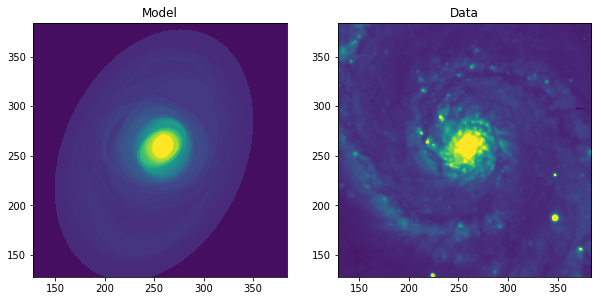

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
limits = [128, 384]

ax1.imshow(model_image, vmin=0, vmax=1000)
ax1.set_title("Model")
ax1.set_xlim(limits)
ax1.set_ylim(limits)

ax2.imshow(data, vmin=0, vmax=1000)
ax2.set_title("Data")
ax2.set_xlim(limits)
ax2.set_ylim(limits)

Finally, subtract model from data:


(128, 384)

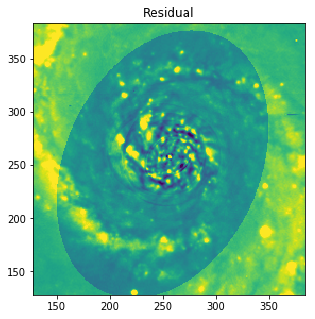

In [5]:
residual = data - model_image

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(residual, vmin=-200, vmax=200)
limits = [128, 384]
ax.set_title("Residual")
ax.set_xlim(limits)
ax.set_ylim(limits)

## Elliptical galaxy test image

Of course, M51 is not the best object to test this procedure, since the non-elliptical contamination is so significant.

Better results for demo purposes can be obtained from a "true" elliptical galaxy. We chose a public-domain image of M105 as published at asd.gsfc.nasa.gov.

We repeat the procedure above but this time passing an `EllipseGeometry` instance to the `Ellipse` constructor, since the galaxy center does not coincide with the image frame center. We also pass first guess values for the ellipticity and position angle parameters, gleaned from visually inspecting the image.

(The variable names below will overwrite the ones defined above).

In [6]:
url = 'https://github.com/astropy/photutils-datasets/raw/master/data/isophote/M105-S001-RGB.fits'
path = download_file(url)
hdu = fits.open(path)
data = hdu[0].data[0]
hdu.close()

In [7]:
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
g = EllipseGeometry(530., 511, 10., 0.1, 10./180.*np.pi)
g.find_center(data)

ellipse = Ellipse(data, geometry=g)
isolist = ellipse.fit_image()

INFO: Found center at x0 = 530.0, y0 = 512.0 [photutils.isophote.geometry]


In [8]:
fill = np.mean(data[20:120, 20:120])
model_image = build_ellipse_model(data.shape, isolist, fill=fill)
residual = data - model_image

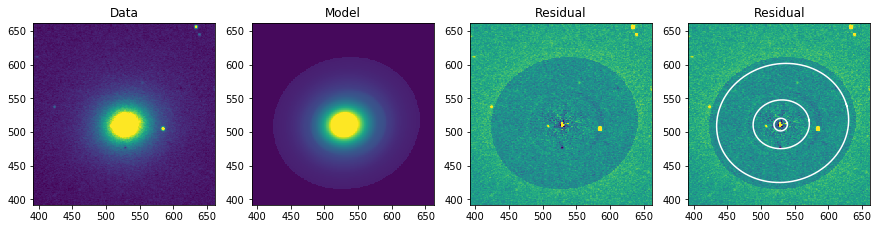

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
limits = [512-120, 512+150]
ax1.imshow(data, vmin=1464., vmax=1480.)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("Data")

ax2.imshow(model_image, vmin=1464., vmax=1480.)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("Model")

ax3.imshow(residual, vmin=-3, vmax=3)
ax3.set_xlim(limits)
ax3.set_ylim(limits)
ax3.set_title("Residual")

ax4.imshow(residual, vmin=-3, vmax=3)
ax4.set_xlim(limits)
ax4.set_ylim(limits)
ax4.set_title("Residual")

# overplot a few isophotes on the residual map
iso1 = isolist.get_closest(10.)
iso2 = isolist.get_closest(40.)
iso3 = isolist.get_closest(100.)

plt.axis([512-120, 512+150, 512-120, 512+150])
x, y, = iso1.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso2.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso3.sampled_coordinates()
plt.plot(x, y, color='white')

The residuals in more detail.

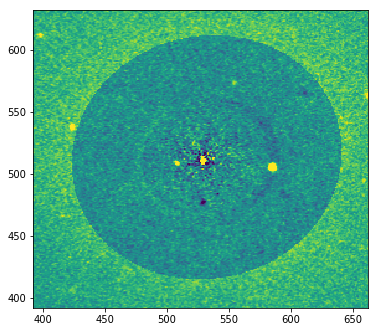

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.axis([512-120, 512+150, 512-120, 512+120])
ax.imshow(residual, vmin=-2, vmax=2)

Note how the residuals are affected by the bright star image about 50 pixels to the right of the nucleus. The isophote that intercepts that star contains a significant non-elliptical component caused by the inclusion of the bright star in the intensity sample extracted from the image. This is a good candidate to be processed by sigma-clipping, as explained in the `isophote_example2.ipynb` notebook.

Out of curiosity, lets see how the radial profiles look.

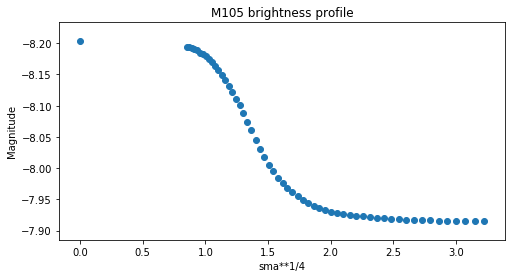

In [11]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))
plt.title("M105 brightness profile")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

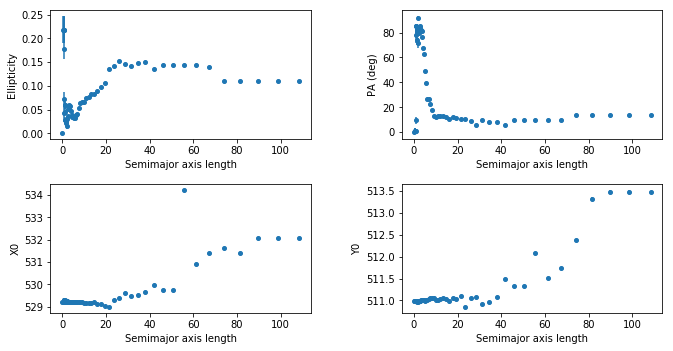

In [12]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

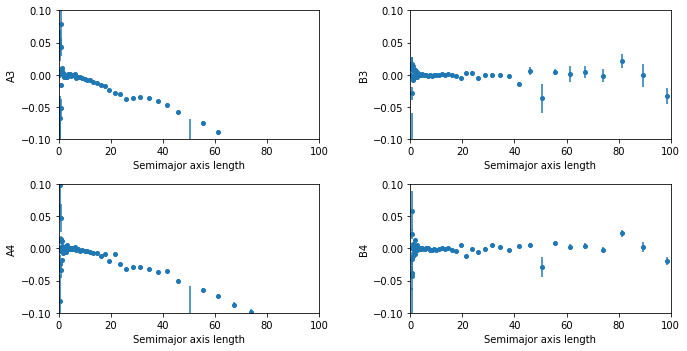

In [13]:
plt.figure(figsize=(10, 5))
plt.figure(1)
limits = [0., 100., -0.1, 0.1]

plt.subplot(221)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.a3, yerr=isolist.a3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A3')

plt.subplot(222)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.b3, yerr=isolist.b3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('B3')

plt.subplot(223)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.a4, yerr=isolist.a4_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A4')

plt.subplot(224)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.b4, fmt='o', yerr=isolist.b4_err, markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('B4')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Note how the presence of the bright star causes a significant non-elliptical component to appear around a semimajor axis length of ~50 pixels.

Lets repeat the procedure with sigma-clipping enabled to remove the star and see the effect on the residual image.

Note that there is no need to create a new `Ellipse` instance, since nothing changed in either the input pixel map nor the input ellipse geometry.

In [14]:
isolist2 = ellipse.fit_image(sclip=3., nclip=3)

fill = np.mean(data[20:120, 20:120])
model_image2 = build_ellipse_model(data.shape, isolist2, fill=fill)
residual2 = data - model_image2

Plot residuals using a very narrow range for the pixel values.

(392, 662)

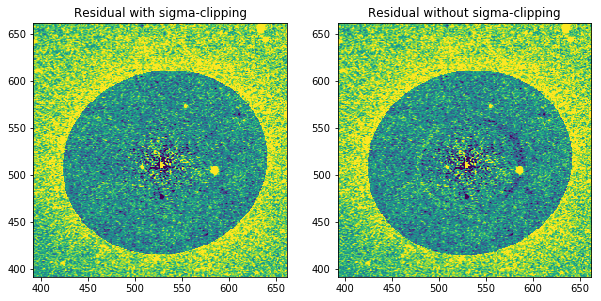

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
limits = [512-120, 512+150]
ax1.imshow(residual2, vmin=-1, vmax=1)
ax1.set_title('Residual with sigma-clipping')
ax1.set_xlim(limits)
ax1.set_ylim(limits)

ax2.imshow(residual, vmin=-1, vmax=1)
ax2.set_title('Residual without sigma-clipping')
ax2.set_xlim(limits)
ax2.set_ylim(limits)